# Neurokit <code>get_segments()</code> Function Overview

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os, wget
import pyedflib  # to read EDF files

import neurokit2 as nk  # for ECG preprocessing and segmentation

from scipy.linalg import svd
from scipy.signal import find_peaks

In [2]:
# # Run this cell only if you need to download the dataset
# !cd .. && mkdir data\raw && cd data\raw
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r01.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r04.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r07.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r08.edf
# !python -m wget https://physionet.org/files/adfecgdb/1.0.0/r01.edf -o ../data/raw/r10.edf

In [3]:
edf_file = "r01.edf"
edf_path = os.path.join("..", "data", "raw", edf_file)
plot_fig_path = os.path.join("..", "reports", "figures")

In [4]:
# Load EDF file
edf = pyedflib.EdfReader(edf_path)

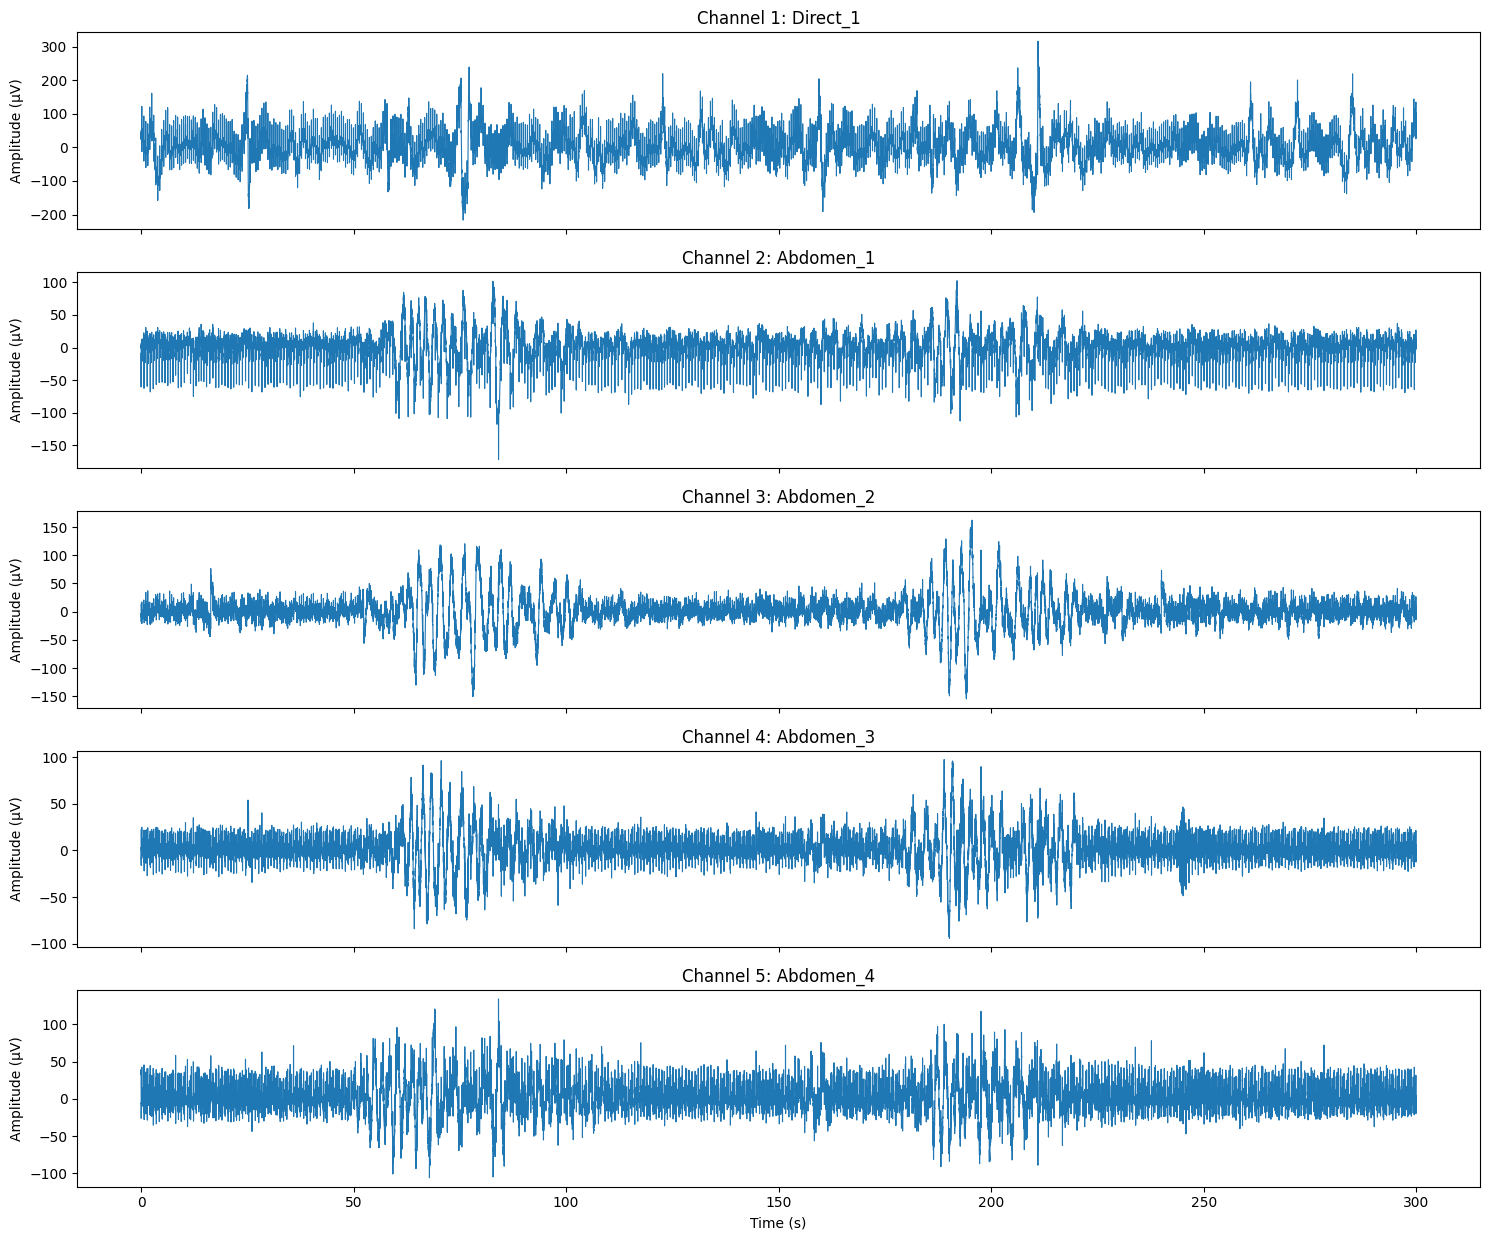

In [5]:
# Get signal info
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
sampling_rate = edf.getSampleFrequency(0)
signal_duration = edf.getFileDuration()
n_samples = edf.getNSamples()[0]
time_vector = np.linspace(0, signal_duration, n_samples)

# Create subplots
fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2.5 * n_channels), sharex=True)

# Plot each channel with its label
for i in range(n_channels):
    signal = edf.readSignal(i)
    axes[i].plot(time_vector, signal, linewidth=0.8)
    axes[i].set_title(f"Channel {i+1}: {channel_labels[i]}")
    axes[i].set_ylabel("Amplitude (µV)")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.savefig(os.path.join(plot_fig_path, 'full-channels-ecg.png'))
plt.show()

In [6]:
direct_signal = edf.readSignal(0)
abdomen_signal = edf.readSignal(1) # 1 = Abdomen_1, 2 = Abdomen_2, 3 = Abdomen_3, 4 = Abdomen_4

# I will not close the file in order to consult different signals later

onsets, durations, labels = edf.readAnnotations() # starting times, duration (in seconds), labels
print("1st onset:", onsets[0]) # the first onset time in seconds
print("1st peak duration:", durations[0]) # -1 if no duration is given
print("1st label:", labels[0]) # the label of the first annotation

1st onset: 0.183
1st peak duration: -1.0
1st label: QRS


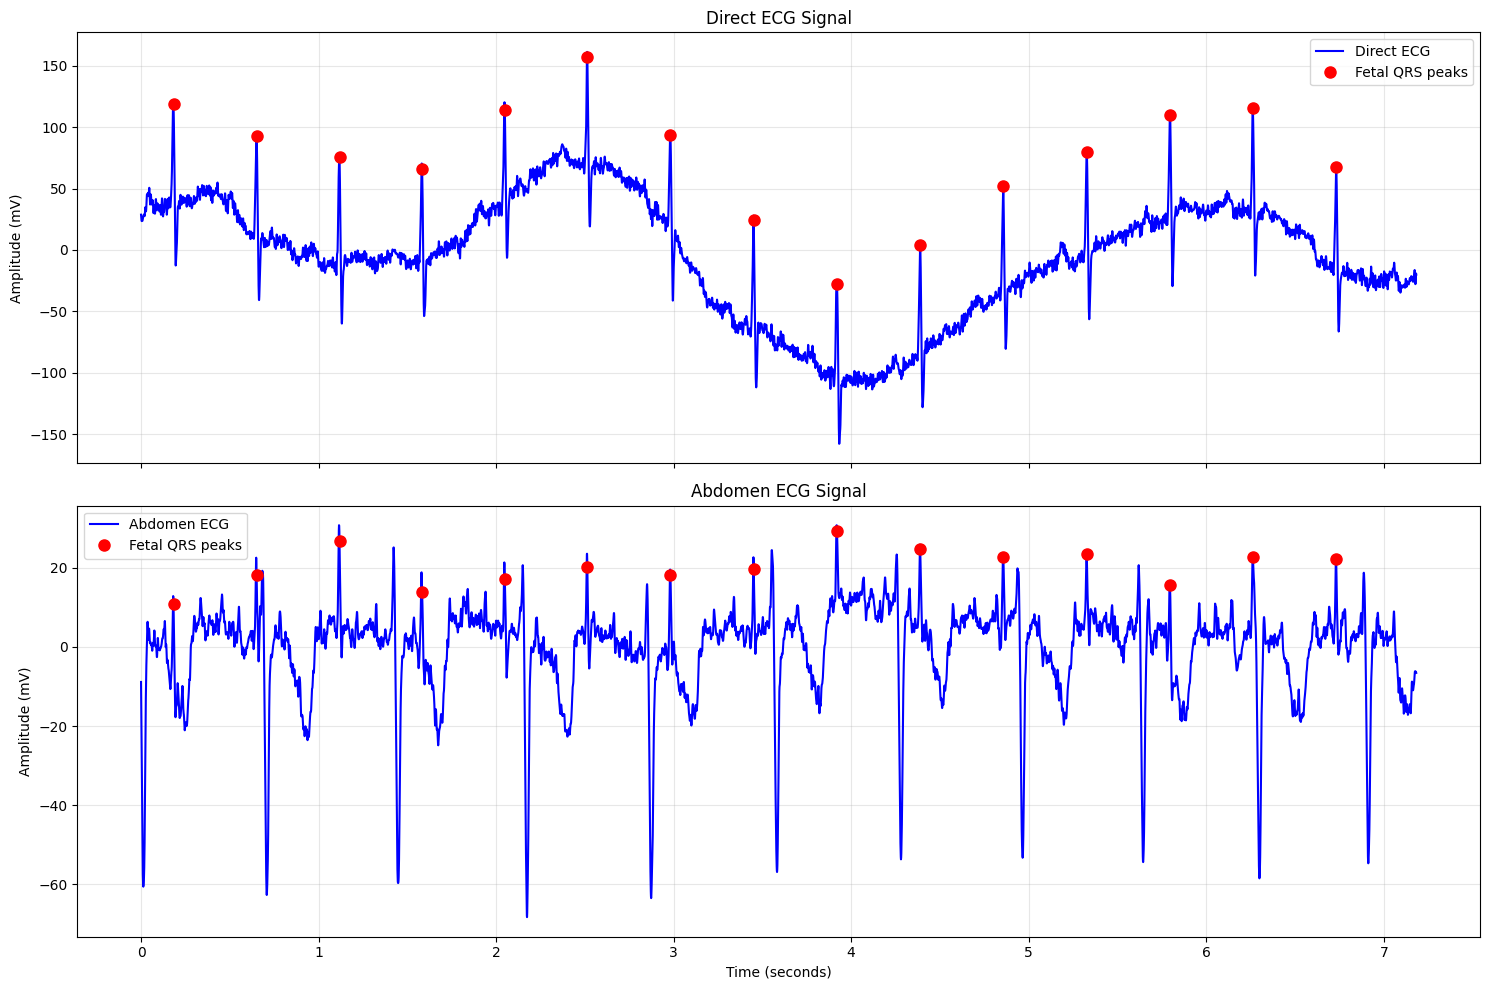

In [7]:
first_onset = onsets[0]
first_label = labels[0]

window_duration = 7.0 # Let's use 5 seconds window
start_time = max(0, first_onset - window_duration)
end_time = first_onset + window_duration

# Convert to sample indices
start_sample = int(start_time * sampling_rate)
end_sample = int(end_time * sampling_rate)

# Extract the signal segment
direct_signal_segment = direct_signal[start_sample:end_sample]
abdomen_signal_segment = abdomen_signal[start_sample:end_sample]
direct_time_segment = np.linspace(start_time, end_time, len(direct_signal_segment))
abdomen_time_segment = np.linspace(start_time, end_time, len(abdomen_signal_segment))

# Get the onsets within the specified time window and interpolate their values
onsets_in_window = onsets[(onsets >= start_time) & (onsets <= end_time)]
direct_onset_values = np.interp(onsets_in_window, direct_time_segment, direct_signal_segment)
abdomen_onset_values = np.interp(onsets_in_window, abdomen_time_segment, abdomen_signal_segment)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Direct signal
ax1.plot(direct_time_segment, direct_signal_segment, 'b-', linewidth=1.5, label='Direct ECG')
ax1.plot(onsets_in_window, direct_onset_values, 'ro', markersize=8, label="Fetal QRS peaks")
ax1.set_ylabel('Amplitude (mV)')
ax1.set_title(f'Direct ECG Signal')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Abdomen signal
ax2.plot(abdomen_time_segment, abdomen_signal_segment, 'b-', linewidth=1.5, label='Abdomen ECG')
ax2.plot(onsets_in_window, abdomen_onset_values, 'ro', markersize=8, label="Fetal QRS peaks")
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude (mV)')
ax2.set_title(f'Abdomen ECG Signal')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(plot_fig_path, 'direct-and-abdomen-segments.png'))
plt.show()